# Яндекс-Афиша

**Описание проекта.**
Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Предстоит изучить изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

## Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.columns = ['device','session_end','source_id','session_start','uid']

In [5]:
visits['session_end'] = pd.to_datetime(visits['session_end'], format="%Y-%m-%d %H:%M:%S")
visits['session_start'] = pd.to_datetime(visits['session_start'], format="%Y-%m-%d %H:%M:%S")
visits = visits.drop_duplicates()

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
session_end      359400 non-null datetime64[ns]
source_id        359400 non-null int64
session_start    359400 non-null datetime64[ns]
uid              359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
orders.columns = ['buy_time','revenue','uid']
orders['buy_time'] = pd.to_datetime(orders['buy_time'], format="%Y-%m-%d %H:%M:%S")
orders = orders.drop_duplicates()

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_time    50415 non-null datetime64[ns]
revenue     50415 non-null float64
uid         50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [11]:
costs = costs.rename(columns = {'dt': 'marketing_datetime'})
costs['marketing_datetime'] = pd.to_datetime(costs['marketing_datetime'], format="%Y-%m-%d %H:%M:%S")
costs = costs.drop_duplicates()

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id             2542 non-null int64
marketing_datetime    2542 non-null datetime64[ns]
costs                 2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 79.4 KB


## Расчет метрик и графики

### Продуктовые метрики

**Рассчитаем продуктовые метрики `DAU`, `WAU`, `MAU`.**

In [13]:
visits['session_date'] = visits['session_start'].dt.date
visits['session_year']  = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week']  = visits['session_start'].dt.week

In [14]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'})
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})

In [15]:
print('Среднее количество уникальных пользователей в день', dau_total['uid'].mean())
print('Среднее количество уникальных пользователей в неделю', wau_total['uid'].mean())
print('Среднее количество уникальных пользователей в месяц', mau_total['uid'].mean())

Среднее количество уникальных пользователей в день 907.9917582417582
Среднее количество уникальных пользователей в неделю 5716.245283018868
Среднее количество уникальных пользователей в месяц 23228.416666666668


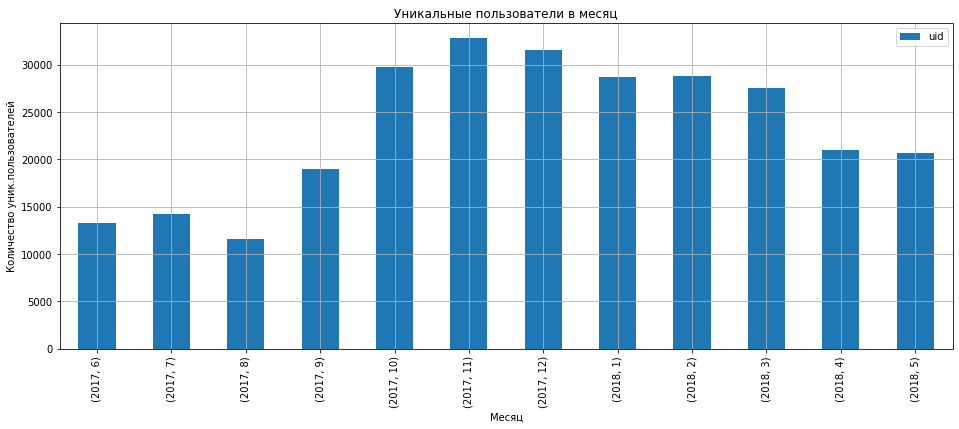

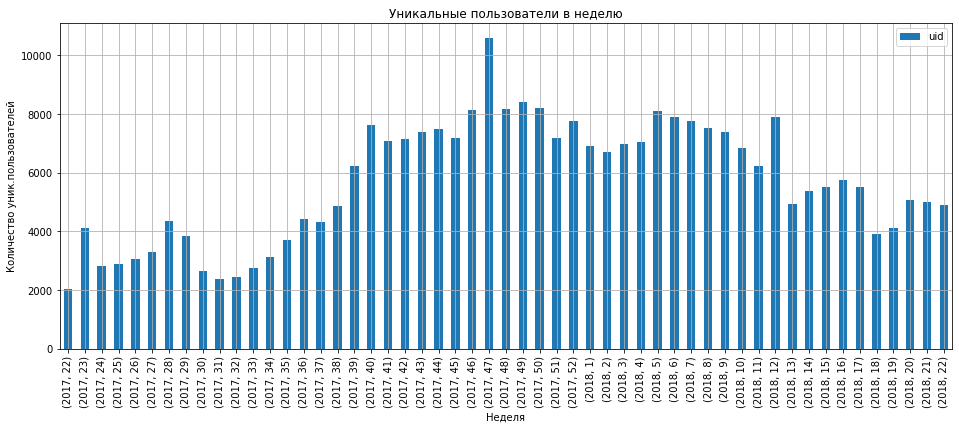

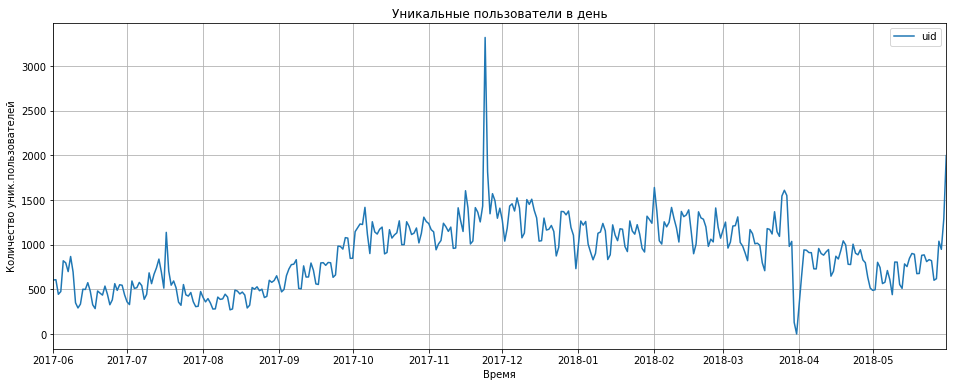

In [16]:
ax = mau_total.plot.bar(grid=True,figsize=(16,6),title='Уникальные пользователи в месяц')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество уник.пользователей')
bx = wau_total.plot.bar(grid=True,figsize=(16,6),title='Уникальные пользователи в неделю')
bx.set_xlabel('Неделя')
bx.set_ylabel('Количество уник.пользователей')
cx = dau_total.plot.line(grid=True,figsize=(16,6),title='Уникальные пользователи в день') # тут уместнее сделать линейный график
cx.set_xlabel('Время')
cx.set_ylabel('Количество уник.пользователей')
plt.show()

Количество уникальных пользователей с лета к концу года растет,после НГ начинает потихоньку падать.

**Посчитаем сколько раз за день пользователи заходят на сайт.**

In [17]:
run_count = visits.groupby('session_date').agg({'uid': 'count'})
print('Среднее количество визитов в день',run_count['uid'].mean())

Среднее количество визитов в день 987.3626373626373


Средняя посещаемость чуть выше чем посещаемость уникальных пользователей. Вполне возможно графики будут похожи.

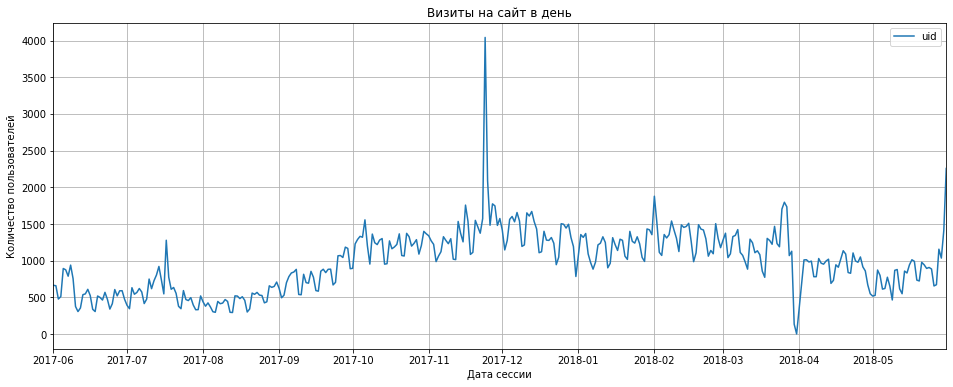

In [18]:
run_count.plot.line(grid=True,figsize=(16,6),title='Визиты на сайт в день')
plt.xlabel('Дата сессии')
plt.ylabel('Количество пользователей')
plt.show()

Графики очень похожи. Интересный выброс вверх в конце ноября 2017 и вниз до нуля в конце марта 2018. В первом случае, возможно наложились друг на друга самые ожидаемые ивенты и на сайт зашло в разы больше пользователей за билетали. Во втором случаем возможно произошел технический сбой и сайт был недоступен. На месячном и недельном графике ажиотаж в это время виден, сбой во втором случае особо не заметен и "сглажен" остальными данными

**Узнаем продолжительность пользовательской сессии.**

In [19]:
visits['session_lenght_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits['session_lenght_sec'].mean()

643.506488592098

Почти 11 минут. Взглянем на распределение.

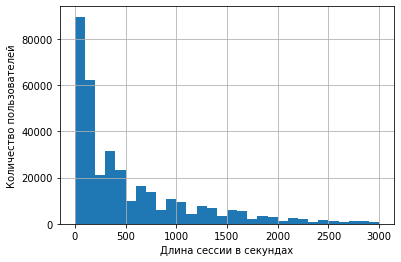

In [20]:
visits['session_lenght_sec'].hist(bins=30,range=(0,3000))
plt.xlabel('Длина сессии в секундах')
plt.ylabel('Количество пользователей')
plt.show()

In [21]:
visits['session_lenght_sec'].value_counts().head(10)

60     53029
0      35794
120    35748
180    26672
240    21085
300    17005
360    14316
420    12301
480    10973
540     9722
Name: session_lenght_sec, dtype: int64

Не похоже на нормальное распределение,поэтому можно рассчитать моду.

In [22]:
visits['session_lenght_sec'].mode()

0    60
dtype: int64

60 секунд судя по моде. Но по `value_counts` можно увидеть и понять истинное распределение. Нулёвых сессий довольно много.

**Применим когортный анализ и рассчитаем `Retention Rate`. Разобьём пользователей на месяцные когорты.**

In [23]:
first_activity_date = visits.groupby(['uid'])['session_start'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')

In [24]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')

In [25]:
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month']) # вычислим lifetime
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() # когорты

In [26]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [27]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] # Retention rate

In [28]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)

In [29]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


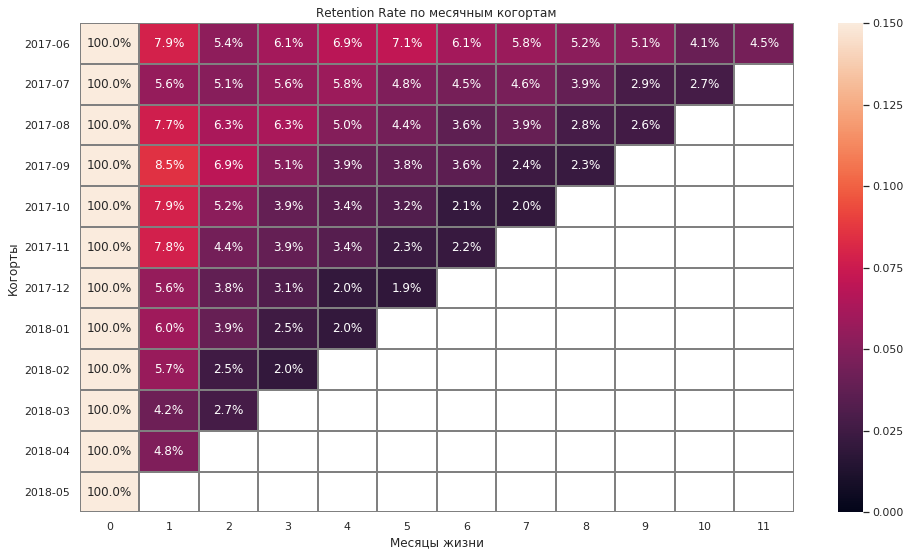

In [30]:
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Retention Rate по месячным когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',vmin=0, vmax=0.15,
            xticklabels='auto', yticklabels=('2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12',
                                             '2018-01','2018-02','2018-03','2018-04', '2018-05'))
plt.xlabel('Месяцы жизни')
plt.ylabel('Когорты')
plt.show()

Не очень-то люди привязаны к сервису. На 1 месяц "жизни" когорт падение везде катастрофическое. На дальше падение уже не такое критичное. Люди заходят купить билеты, а вот анонсы мероприятий и другую информацию видимо не часто смотрят, узнают из других источников.

**Рассчитаем средний Retention Rate по месяцам жизни.**

In [31]:
for column in retention_pivot:
    print('Средний Retention Rate на {} месяц жизни'.format(column),retention_pivot[column].mean())

Средний Retention Rate на 0 месяц жизни 1.0
Средний Retention Rate на 1 месяц жизни 0.06516659710392834
Средний Retention Rate на 2 месяц жизни 0.0463326221636773
Средний Retention Rate на 3 месяц жизни 0.0427599039289249
Средний Retention Rate на 4 месяц жизни 0.040594569103002624
Средний Retention Rate на 5 месяц жизни 0.03944382761536506
Средний Retention Rate на 6 месяц жизни 0.036956590864871436
Средний Retention Rate на 7 месяц жизни 0.03750911822830765
Средний Retention Rate на 8 месяц жизни 0.03546464942835624
Средний Retention Rate на 9 месяц жизни 0.03515906326345746
Средний Retention Rate на 10 месяц жизни 0.03406249831394499
Средний Retention Rate на 11 месяц жизни 0.044950599592729464


Средняя падает от месяца к месяцу. А на 11 месяц выросло. С ростом lifetime'а количество значений падает на 1, таким образом в последнем месяце осталось одно значение ретеншиона. Считаю,что оно не показательно.

**Вывод:** У пользователей очень низкий `Retention Rate`. Примерно 1000 визитов на сайт в среднем каждый день. БОльшая часть пользователей проводит на сайте от одной до нескольких минут. Люди заходят узнать/купить билеты куда-нибудь и всё, много времени там не проводят и особо не возвращаются.

### Метрики электронной коммерции

Посмотрим, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.
Для этого выделим из датафреймов данные с первым визитом и первой покупкой, склеим и найдем разницу во времени.

In [32]:
first_order_time = orders.groupby('uid')['buy_time'].min()
first_order_time.name = 'first_order_time'
orders = orders.join(first_order_time, on='uid')

In [33]:
part1 = visits[['uid','first_activity_date']]
part2 = orders[['uid','first_order_time']]
part1.drop_duplicates().reset_index(drop=True).head()
part2.drop_duplicates().reset_index(drop=True).head()

,uid,first_order_time
0,10329302124590727494,2017-06-01 00:10:00
1,11627257723692907447,2017-06-01 00:25:00
2,17903680561304213844,2017-06-01 00:27:00
3,16109239769442553005,2017-06-01 00:29:00
4,14200605875248379450,2017-06-01 07:58:00


In [34]:
join_to_buy = part1.merge(part2, on='uid') #склеим
join_to_buy = join_to_buy.drop_duplicates().reset_index(drop=True)

In [35]:
join_to_buy['change'] = (join_to_buy['first_order_time'] - join_to_buy['first_activity_date']) / np.timedelta64(1, 'm')
join_to_buy.head()

,uid,first_activity_date,first_order_time,change
0,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:25:00,20.0
1,16007536194108375387,2017-09-03 21:35:00,2017-09-04 12:46:00,911.0
2,8056418121947262981,2017-06-04 14:17:00,2017-06-25 08:54:00,29917.0
3,18188358787673499603,2018-02-10 12:17:00,2018-02-12 19:48:00,3331.0
4,2307401184189569202,2017-09-23 23:27:00,2017-09-27 09:23:00,4916.0


In [36]:
visits['uid'].nunique() # уникальные пользователи

228169

In [37]:
join_to_buy['change'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: change, dtype: float64

36523 из 228169 пользователей сделали покупки. Из них среднее время между первым визитом и первой покупкой почти 24 тысячи минут. А вот медианное всего 16 минут. Половина что-то покупают достаточно быстро, 75% в течении 48 часов после первого визита. По-видимому много пользователей,которые первую покупку делают через много месяцев после первого визита,оттого и средняя уж очень большая.

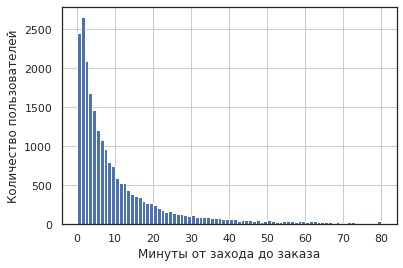

In [38]:
join_to_buy['change'].hist(bins=80, range=(0, 80))
plt.xlabel('Минуты от захода до заказа')
plt.ylabel('Количество пользователей')
plt.show()

Теперь рассчитаем среднее количество покупок на одного покупателя за определённый период. Разобьем на когорты и выделим месяцы. Посчитаем количество пользователей и их платежей.

In [39]:
orders['first_order_month'] = orders['first_order_time'].astype('datetime64[M]')
orders['order_month'] = orders['buy_time'].astype('datetime64[M]')

In [40]:
buys_pivot = orders.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='count',
) 

In [41]:
buys_pivot # сводная показывает количество платежей с течением времени.Нам нужно посчитать средние по суммам.

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0,NaN
2017-07-01,NaN,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2017-08-01,NaN,NaN,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN
2017-09-01,NaN,NaN,NaN,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,5052.0,270.0,202.0,179.0,86.0,105.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3783.0,224.0,159.0,64.0,78.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4095.0,222.0,83.0,70.0,NaN


In [42]:
orders_grouped_by_cohorts = orders.groupby(
    ['first_order_month']
).agg({'uid': 'nunique','revenue': 'count'})
orders_grouped_by_cohorts.columns = ['users','orders_count']
orders_grouped_by_cohorts['mean'] = orders_grouped_by_cohorts['orders_count'] / orders_grouped_by_cohorts['users']
orders_grouped_by_cohorts

,users,orders_count,mean
first_order_month,,,
2017-06-01,2023,4438,2.193772
2017-07-01,1923,2910,1.513261
2017-08-01,1370,2188,1.597080
2017-09-01,2581,3878,1.502518
2017-10-01,4340,6005,1.383641
2017-11-01,4081,5900,1.445724
2017-12-01,4383,5894,1.344741
2018-01-01,3373,4308,1.277201
2018-02-01,3651,4470,1.224322


Июньская когорта самая успешная по средним покупкам. На каждого пользователя в среднем больше 2 покупок. У остальных когорт показатель скромнее. И с каждым месяцем падает. Осенью количество пользователей начинает возрастать динамичнее нежели их покупки. Возможно в деньгах показатель будет другой.

Рассчитаем `средний чек` и как он изменяется от месяца к месяцу.

In [43]:
mean_checks = orders.groupby(
    ['order_month']).agg({'revenue':'sum','buy_time':'count'})
mean_checks.columns = ['revenue','n_orders']
mean_checks['mean_revenue'] = mean_checks['revenue'] / mean_checks['n_orders']
mean_checks

,revenue,n_orders,mean_revenue
order_month,,,
2017-06-01,9557.49,2354,4.060106
2017-07-01,12539.47,2363,5.306589
2017-08-01,8758.78,1807,4.847139
2017-09-01,18345.51,3387,5.416448
2017-10-01,27987.70,5679,4.928280
2017-11-01,27069.93,5659,4.783518
2017-12-01,36388.60,6218,5.852139
2018-01-01,19417.13,4721,4.112927
2018-02-01,25560.54,5281,4.840095


Выручка в уе. И общая выручка и количество платежей к концу календарного года растут. Средний чек около 5 уе. Декабрь самый успешный месяц по показателям выручки.

Выясним, как меняется LTV(`Lifetime Value`) на покупателя по когортам. LTV — накопительная метрика. Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев. Маржинальность — 100%. Отразим изменения метрики во времени на графике.

In [44]:
cohorts = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts # выручка по когортам и месяцам

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [45]:
cohort_sizes = (
    orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [46]:
#склеим данные
cohorts_upd = pd.merge(cohorts, cohort_sizes, on='first_order_month')
cohorts_upd

,first_order_month,order_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023
...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533
75,2018-04-01,2018-04-01,10600.69,2276
76,2018-04-01,2018-05-01,1209.92,2276
77,2018-05-01,2018-05-01,13925.76,2988


In [47]:
margin = 1 # маржинальность 100%

In [48]:
cohorts_upd['gross_profit'] = cohorts_upd['revenue'] * margin
cohorts_upd['age'] = (cohorts_upd['order_month'] - cohorts_upd['first_order_month']) / np.timedelta64(1, 'M')
cohorts_upd['age'] = cohorts_upd['age'].round().astype('int')

In [49]:
cohorts_upd['ltv'] = cohorts_upd['gross_profit'] / cohorts_upd['n_buyers']

In [50]:
pivot_ltv = cohorts_upd.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)

In [51]:
pivot_ltv.cumsum(axis=1).round(2).fillna('-') # сводная таблица по когортам по ltv.

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,-
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,-,-
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,-,-,-
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,-,-,-,-
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,-,-,-,-,-
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,-,-,-,-,-,-
2018-01-01,4.14,4.43,4.73,4.88,4.94,-,-,-,-,-,-,-
2018-02-01,4.16,4.44,4.51,4.59,-,-,-,-,-,-,-,-


Поскольку лайвтаймы у всех разные,возьмем первые 7 когорт, и данные за их первые 6 месяцев жизни.

In [52]:
ltv_mean = pivot_ltv.query('first_order_month < "2018-01-01"')
ltv_mean = ltv_mean[[0,1,2,3,4,5]]

Посчитаем сумму по ltv за 6 месяцев для каждой когорты. и выведем график.

In [53]:
ltv_mean['ltv_sum'] = 0
ltv_mean.loc['2017-06-01','ltv_sum'] = ltv_mean.loc['2017-06-01'].sum()
ltv_mean.loc['2017-07-01','ltv_sum'] = ltv_mean.loc['2017-07-01'].sum()
ltv_mean.loc['2017-08-01','ltv_sum'] = ltv_mean.loc['2017-08-01'].sum()
ltv_mean.loc['2017-09-01','ltv_sum'] = ltv_mean.loc['2017-09-01'].sum()
ltv_mean.loc['2017-10-01','ltv_sum'] = ltv_mean.loc['2017-10-01'].sum()
ltv_mean.loc['2017-11-01','ltv_sum'] = ltv_mean.loc['2017-11-01'].sum()
ltv_mean.loc['2017-12-01','ltv_sum'] = ltv_mean.loc['2017-12-01'].sum()

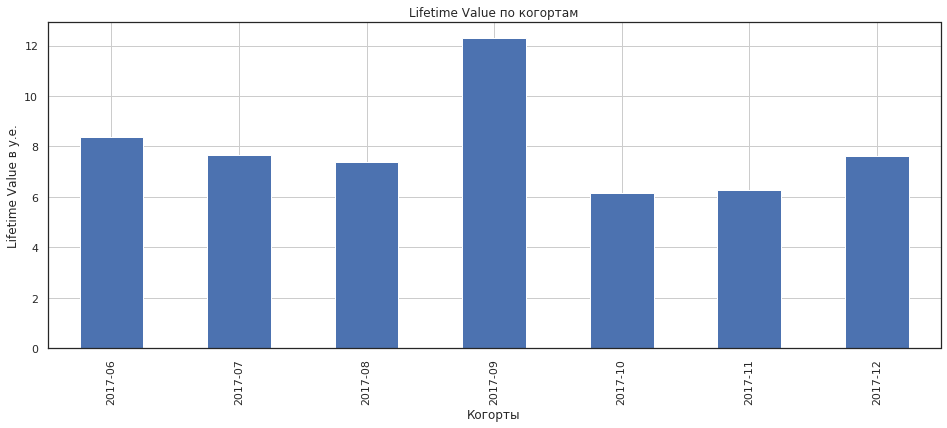

In [54]:
ax = ltv_mean['ltv_sum'].plot.bar(grid=True,figsize=(16,6),title='Lifetime Value по когортам')
ax.set_xlabel('Когорты')
ax.set_ylabel('Lifetime Value в у.е.')
ax.set_xticklabels(['2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12'])
plt.show()

`Lifetime Value` у когорт разный. Самый высокий у сентябрьской когорты, больше 12 уе. У остальных от 6 до 8.
Судя по предшествующим данным, видим выброс на 3 месяц жизни сентябрьской когорты. Несложно посчитать,что это декабрь, а в декабре у нас как раз самая большая выручка. Предположительно, именно сентябрьская когорта активнее других делала заказы в декабре.

**Вывод:** Выручка начинает расти с конца лета и до конца года, количество покупок тоже. Несмотря на это, среднее количество покупок на пользователя падает(количество покупателей растет быстрее количества заказов). Судя по LTV. клиенты пришедшие летом и осенью на дистанции 6 месяцев тратят больше денег нежели остальные. Последние 3-4 месяца в году самые большие по выручке.

### Маркетинговые метрики

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Посмотрим изменения метрик во времени.

In [55]:
costs['costs'].sum() # общие затраты на маркетинг

329131.62

In [56]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()

In [57]:
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


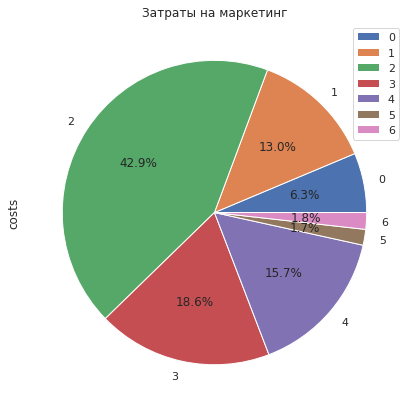

In [58]:
costs_by_source.plot(kind='pie',y ='costs',autopct='%1.1f%%',figsize=(7,7),title='Затраты на маркетинг')

3 источник - основной. Остальные имеют доли поменьше.

In [59]:
costs['marketing_month'] = costs['marketing_datetime'].astype('datetime64[M]')
costs_month = costs.groupby('marketing_month').agg({'costs': 'sum'}).reset_index()

In [60]:
costs_month

,marketing_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


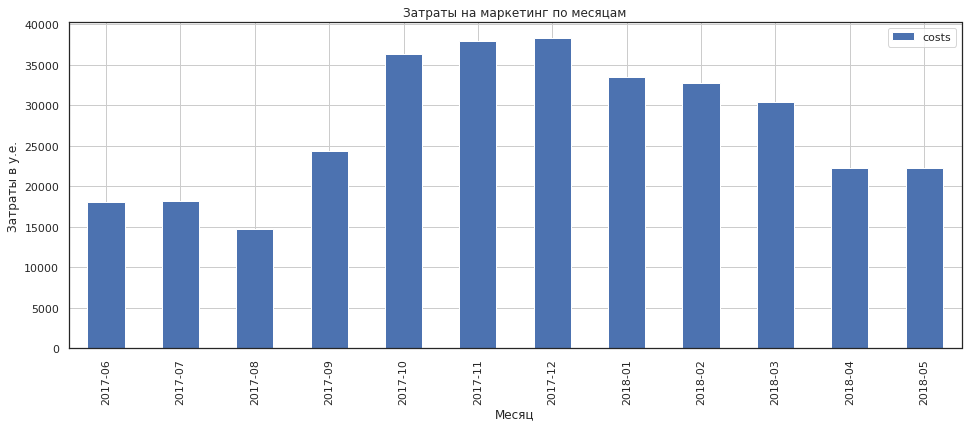

In [61]:
ax = costs_month.plot.bar(x='marketing_month',y='costs',grid=True,figsize=(16,6),title='Затраты на маркетинг по месяцам')
ax.set_ylabel('Затраты в у.е.')
ax.set_xlabel('Месяц')
ax.set_xticklabels(['2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03',
                   '2018-04','2018-05'])
plt.show()

Видим как изменяются затраты во времени помесячно. Рост к концу года и потом плавное снижение. График похож на графики по выручке. Это доказывает что затраты и выручка прямо взаимосвязаны.

Теперь рассчитаем средний CAC(затраты на привлечение нового клиента) на одного покупателя для всего проекта и для каждого источника трафика. Отразим изменения метрик на графиках.

In [62]:
cac_total = costs['costs'].sum() / orders['uid'].nunique()
cac_total

9.011626098622786

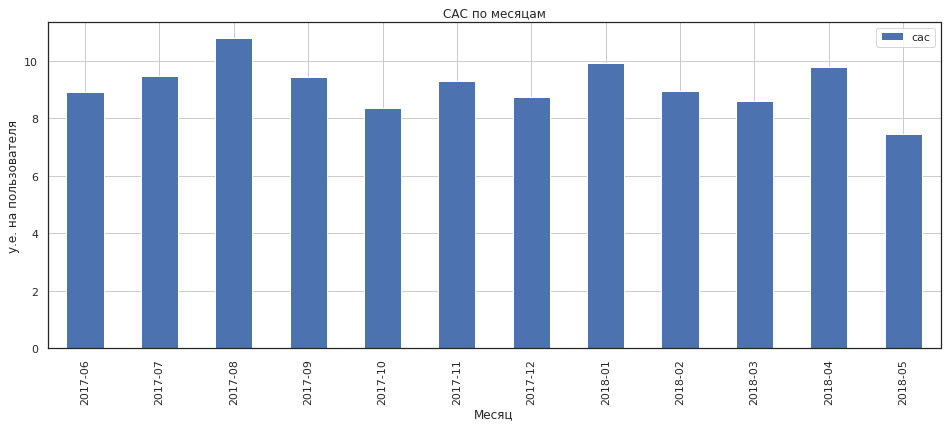

In [63]:
n_users = orders.groupby(['first_order_month']).agg({'uid': 'nunique'}).reset_index()
n_users = n_users.rename(columns={"first_order_month": "marketing_month","uid": "n_users"})
n_users = n_users.merge(costs_month, on='marketing_month')
n_users['cac'] = n_users['costs'] / n_users['n_users']
ax = n_users.plot.bar(x='marketing_month',y='cac', grid=True, figsize=(16,6),title='CAC по месяцам')
ax.set_ylabel('у.е. на пользователя')
ax.set_xlabel('Месяц')
ax.set_xticklabels(['2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03',
                   '2018-04','2018-05'])
plt.show()

In [64]:
costs_pivot = costs.pivot_table(
    index='source_id',columns='marketing_month',values='costs',aggfunc='sum')
costs_pivot # сводная таблица как распределены затраты по источникам и месяцам

marketing_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


Теперь узнаем количество привлеченных пользователей по источникам. Можно взять параметры источника из `visits` по `uid`.

In [65]:
# Один и тот же пользователь мог заходить на сайт из разных источников, поэтому будем считать главным тот который был первым.
users_source = visits.sort_values(by='session_start').groupby('uid')['source_id'].first().reset_index()
orders = pd.merge(orders,users_source, on='uid')

In [66]:
n_users_pivot = orders.pivot_table(
    index='source_id',columns='first_order_month',values='uid',aggfunc='nunique') 
n_users_pivot # количество платящих пользователей по источникам и месяцам

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
source_id,,,,,,,,,,,,,
1,190.0,160.0,113.0,227.0,340.0,324.0,331.0,238.0,275.0,281.0,179.0,241.0,NaN
2,235.0,208.0,123.0,221.0,396.0,398.0,381.0,292.0,293.0,337.0,210.0,412.0,NaN
3,638.0,512.0,337.0,781.0,1152.0,1216.0,1317.0,1006.0,1092.0,959.0,619.0,844.0,NaN
4,413.0,517.0,338.0,590.0,1172.0,1177.0,1377.0,1032.0,1106.0,1081.0,688.0,804.0,1.0
5,384.0,423.0,360.0,589.0,945.0,693.0,771.0,633.0,678.0,528.0,430.0,497.0,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,68.0,52.0,61.0,87.0,126.0,145.0,121.0,80.0,84.0,161.0,43.0,60.0,NaN
10,95.0,51.0,37.0,86.0,209.0,128.0,85.0,92.0,123.0,186.0,107.0,130.0,NaN


Появился 7 источник. В визитах видимо он есть, а в затратах по маркетингу это нет, денег туда не тратили. И один визит с 2018.06 тоже здесь. **Теперь можем посчитать `САС` в сводной таблице для каждого источника.**

In [67]:
cac_pivot = costs_pivot / n_users_pivot
cac_pivot # сводная показывает сас по источникам трафика и месяцам

,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
source_id,,,,,,,,,,,,,
1,5.924263,6.705500,8.423097,6.616784,6.811029,7.546790,7.073112,9.185630,8.016291,6.736975,7.416145,6.089668,NaN
2,10.329277,11.216875,14.723984,13.509774,12.234848,13.185126,12.855118,14.238836,15.270785,11.700712,14.255714,6.527767,NaN
3,12.118574,14.989004,18.230089,12.757426,13.660799,14.001102,12.315505,14.720457,13.029817,13.640094,15.019079,11.150972,NaN
4,8.510412,6.827331,9.518817,8.800441,5.478532,4.578437,5.577683,5.651928,5.164521,5.515143,6.407689,5.241555,NaN
5,6.812813,7.087801,6.070222,6.535042,6.103069,9.127475,7.616757,8.485814,7.479808,8.578826,8.142209,7.383421,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.194412,5.818077,4.080820,4.777241,4.836587,4.711586,5.437851,6.839500,6.565476,2.983168,8.685814,6.036167,NaN
10,3.307579,6.467059,6.285676,5.356628,3.001148,6.190313,7.598353,6.677717,3.909593,2.830161,3.628505,3.152769,NaN


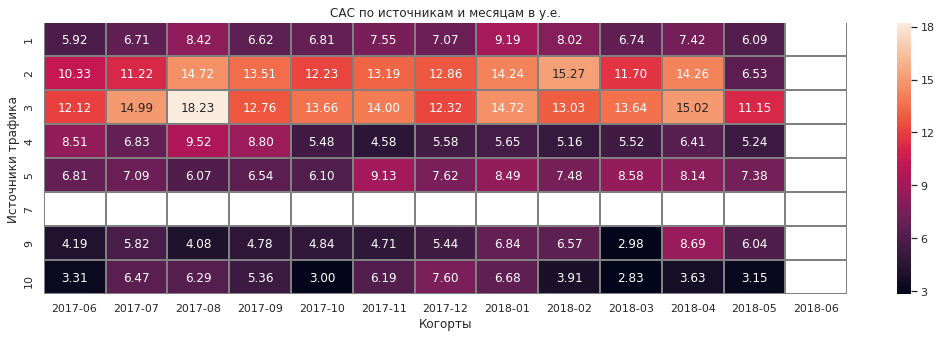

In [68]:
sns.set(style='white')
plt.figure(figsize=(18,5))
plt.title('CAC по источникам и месяцам в у.е.')
sns.heatmap(cac_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray',xticklabels=('2017-06','2017-07','2017-08',
                        '2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04', '2018-05','2018-06'))
plt.xlabel('Когорты')
plt.ylabel('Источники трафика')
plt.show()

3 источник самый затратный на одного пользователя. 9 и 10 менее затратные. Чтобы оценить эффективность каждого источника нужно расчитать `ROMI`(возврат на маркетинговые инвестиции) для них.

In [69]:
cohorts2 = (
    orders.groupby(['first_order_month', 'order_month','source_id'])
    .agg({'revenue': 'sum'})
    .reset_index()
) # выручка по когортам и месяцам и источникам
cohort_sizes2 = (
    orders.groupby(['first_order_month','source_id'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes2.columns = ['first_order_month','source_id','n_buyers'] # когорты по источникам и месяцам
cohorts_all = pd.merge(cohorts2, cohort_sizes2, on=['first_order_month','source_id']).sort_values(
    ['first_order_month', 'order_month','source_id'])
cohorts_all['gross_profit'] = cohorts_all['revenue'] * margin
cohorts_all['age'] = (cohorts_all['order_month'] - cohorts_all['first_order_month']) / np.timedelta64(1, 'M')
cohorts_all['age'] = cohorts_all['age'].round().astype('int')

In [70]:
cohorts_all['ltv'] = cohorts_all['gross_profit'] / cohorts_all['n_buyers'] # считаем параметры
costs_month2 = costs.groupby(['marketing_month','source_id']).agg({'costs': 'sum'}).reset_index()
costs_month2 = costs_month2.rename(columns={"marketing_month":"order_month"})

In [71]:
cohorts_all = pd.merge(cohorts_all, costs_month2, on=['order_month','source_id']).sort_values(
    ['first_order_month', 'order_month','source_id']).reset_index(drop=True)
cohorts_all['cac'] = cohorts_all['costs'] / cohorts_all['n_buyers']
cohorts_all['romi'] = cohorts_all['ltv'] / cohorts_all['cac']

In [72]:
cohorts_all.head(20) # итоговая таблица когорт с показателями

,first_order_month,order_month,source_id,revenue,n_buyers,gross_profit,age,ltv,costs,cac,romi
0,2017-06-01,2017-06-01,1,1378.70,190,1378.70,0,7.256316,1125.61,5.924263,1.224847
1,2017-06-01,2017-06-01,2,1043.68,235,1043.68,0,4.441191,2427.38,10.329277,0.429962
2,2017-06-01,2017-06-01,3,2804.34,638,2804.34,0,4.395517,7731.65,12.118574,0.362709
3,2017-06-01,2017-06-01,4,1959.84,413,1959.84,0,4.745375,3514.80,8.510412,0.557596
4,2017-06-01,2017-06-01,5,1898.89,384,1898.89,0,4.945026,2616.12,6.812813,0.725842
5,2017-06-01,2017-06-01,9,242.69,68,242.69,0,3.568971,285.22,4.194412,0.850887
6,2017-06-01,2017-06-01,10,229.35,95,229.35,0,2.414211,314.22,3.307579,0.729903
7,2017-06-01,2017-07-01,1,414.98,190,414.98,1,2.184105,1072.88,5.646737,0.386791
8,2017-06-01,2017-07-01,2,115.54,235,115.54,1,0.491660,2333.11,9.928128,0.049522
9,2017-06-01,2017-07-01,3,71.97,638,71.97,1,0.112806,7674.37,12.028793,0.009378


In [73]:
output = cohorts_all.pivot_table(
    index=['source_id','first_order_month'], columns='age', values='romi', aggfunc='mean'
)
output.cumsum(axis=1).round(2).head(15)

age                            0     1     2     3     4     5     6     7   \
source_id first_order_month                                                   
1         2017-06-01         1.22  1.61  2.05  2.53  2.88  3.04  3.25  3.47   
          2017-07-01         1.09  1.27  1.84  1.95  2.00  2.07  2.10  2.14   
          2017-08-01         0.89  0.98  1.03  1.07  1.12  1.16  1.19  1.35   
          2017-09-01         0.91  1.09  1.14  1.23  1.23  1.24  1.25  1.30   
          2017-10-01         0.88  1.03  1.07  1.13  1.14  1.16  1.20  1.28   
          2017-11-01         0.98  1.06  1.20  1.33  1.36  1.39  1.40   NaN   
          2017-12-01         0.65  0.70  0.74  0.78  0.79  0.81   NaN   NaN   
          2018-01-01         0.63  0.64  0.66  0.83  0.84   NaN   NaN   NaN   
          2018-02-01         0.58  0.73  0.74  0.81   NaN   NaN   NaN   NaN   
          2018-03-01         1.39  1.80  1.95   NaN   NaN   NaN   NaN   NaN   
          2018-04-01         0.63  0.67   NaN   NaN   NaN   NaN   NaN   NaN   
          2018-05-01         0.86   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         2017-06-01         0.43  0.48  0.51  0.67  0.75  0.79  0.87  0.95   
          2017-07-01         0.75  0.84  0.84  0.86  0.87  0.88  0.90  0.90   
          2017-08-01         0.39  0.43  0.43  0.44  0.45  0.45  0.46  0.47   

age                            8     9     10    11  
source_id first_order_month                          
1         2017-06-01         3.66  3.83  4.00  4.22  
          2017-07-01         2.22  2.34  2.44   NaN  
          2017-08-01         1.54  1.60   NaN   NaN  
          2017-09-01         1.39   NaN   NaN   NaN  
          2017-10-01          NaN   NaN   NaN   NaN  
          2017-11-01          NaN   NaN   NaN   NaN  
          2017-12-01          NaN   NaN   NaN   NaN  
          2018-01-01          NaN   NaN   NaN   NaN  
          2018-02-01          NaN   NaN   NaN   NaN  
          2018-03-01          NaN   NaN   NaN   NaN  
          2018-04-01          NaN   NaN   NaN   NaN  
          2018-05-01          NaN   NaN   NaN   NaN  
2         2017-06-01         1.02  1.06  1.17  1.21  
          2017-07-01         0.91  0.93  0.95   NaN  
          2017-08-01         0.47  0.47   NaN   NaN

Выведем графики и сравним параметры окупаемости за одинаковые время жизни в разрезе источников.

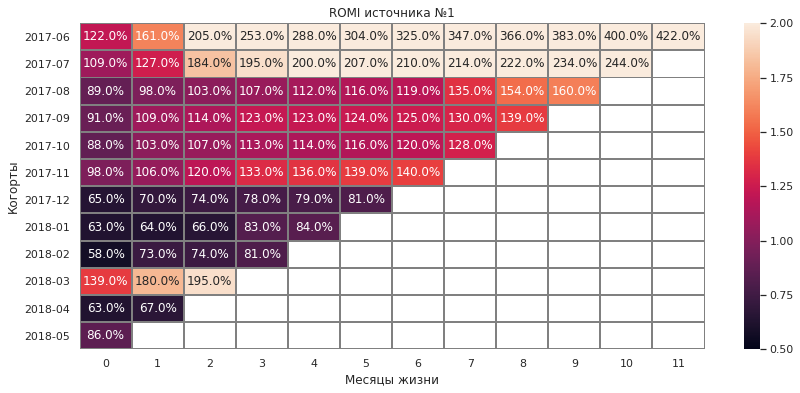

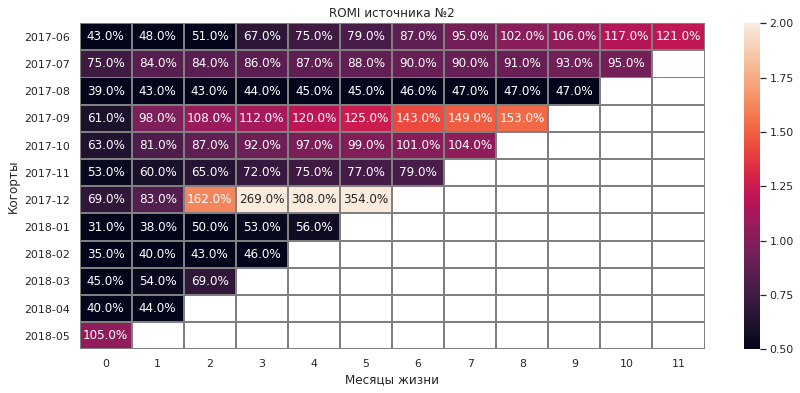

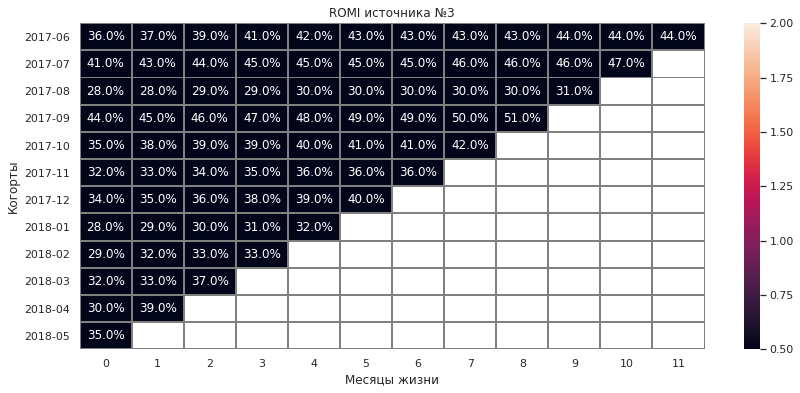

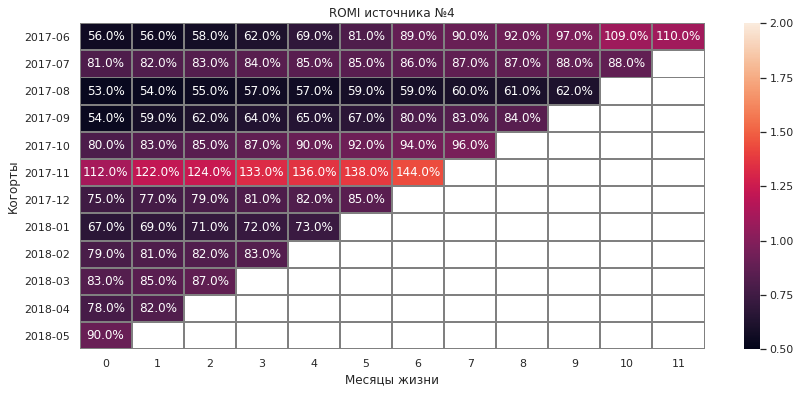

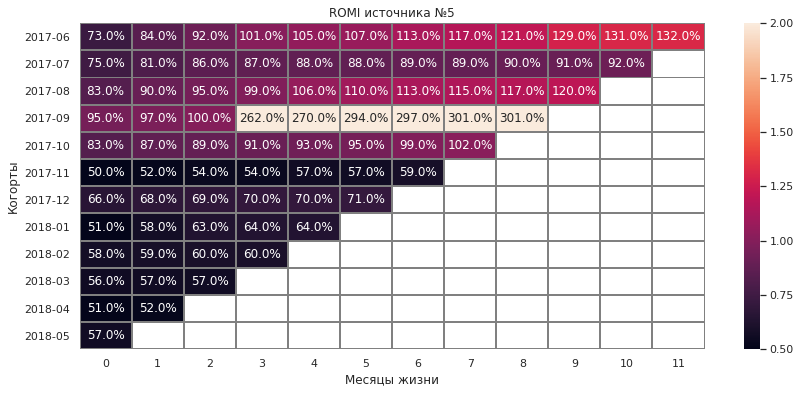

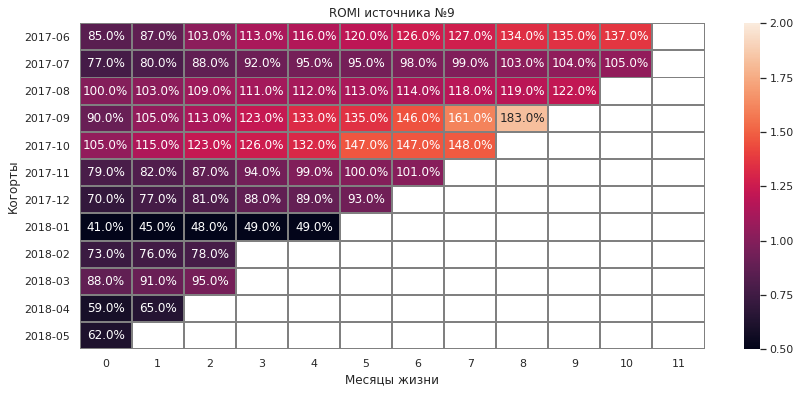

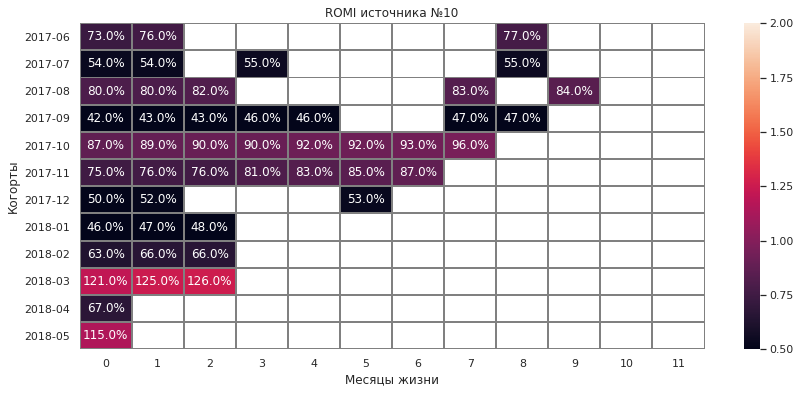

In [74]:
sources = [1, 2, 3, 4, 5, 9, 10] # выведем heatmap по источникам и когоргам
for source in sources:
    sns.set(style='white')
    plt.figure(figsize=(14,6))
    plt.title(f'ROMI источника №{source}')
    sns.heatmap(output.cumsum(axis=1).round(2).loc[[source]], annot=True, fmt='.1%', linewidths=1, linecolor='gray',yticklabels=(
        '2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04', '2018-05',),
               vmin=0.5, vmax=2)
    plt.xlabel('Месяцы жизни')
    plt.ylabel('Когорты')
    plt.show()

В разных когортах источники привлечения окупаются по разному, одни быстрее, другие медленнее. Чем больше пользователей пришло из конкретного испочника и сделали заказ, тем быстрее он окупается.

In [75]:
output.cumsum(axis=1).mean(axis=0) # средняя по "больнице"

age
0     0.671704
1     0.722501
2     0.803012
3     0.881614
4     0.954413
5     1.043761
6     1.069142
7     1.112094
8     1.154756
9     1.144703
10    1.340682
11    1.657971
dtype: float64

В среднем затраты на маркетинг окупаются на 5 месяц. Этот результат можно улучшить, распределив бюджет более эффективно по источникам.

## Итоговые выводы

### Определение источников трафика

3 источник у нас самый расходный(43%) всех затрат, однако завтраты в него не окупились ни у одной когорты. Самые быстроокупающие себя источники,судя по анализу, это 1 и 9. Эффективнее сократить часть расходов с 3 и перебросить их на 1 и 9 источники. Таким образом мы перераспределим расходы на источники от худших к лучшим(по показателю `ROMI`). Полностью сокращать расходы со всех источников и вливать деньги в один - плохая идея, т.к мы не знаем как поведут себя пользователи в будущем. рекомендуется проводить анализ каждые 3-6 месяцев,чтобы смотреть эти показатели и перераспределять рекламный бюджет больше к эффективным источникам. Эффективные источники как правило со временем могут меняться.

### Выводы по метрикам

Продуктовые позволяют понять поведение пользователей. Например для нашего сайта Retention Rate очень низкий уже на следующий месяц. Также можно построить различные воронки действий пользователей и понять на каком этапе у нас проблемы и где её искать.
Можно отметить, что пользователи ближе к концу года более активны, нежели в начале или летом.
Маркетинговые метрики помогают оценить качество расходов и увидеть эффективность расходов в зависимости от когорт, источников и времени. В нашем случае, необходимо перераспределить расходы от менее эффективных источнов к более эффективным опираясь на `LTV`,`CAC` и `ROMI`.
Метрики e-commerce это юнит-экономика. Позволяет определить прибыльность бизнеса,сводные показатели,маржу. У нас на сайте из всех пользователей превратились в покупателей только 16%. В основном пользователи делают покупки в первый месяц своего визита.
Со течением времени количество покупок на пользователя падает,а средний чек не растёт, что не очень хорошо.


### Перспективные когорты

С помощью когортного анализа разделили пользователей на когорты по времени в зависимости от первой покупки. Так вот, по показателям `LTV` и `ROMI` самые перспективные когорты это июньская2017 и сектябрьская2017. Остальные когорты платят хуже. Самая плохая - январская2018. В не зависимости от источников привлечения. Возможно к этим месяцам стоит увеличивать маркетинговый бюджет в будущем и привлекать их из наиболее эффективных источников трафика.